In [2]:
import sys
from pathlib import Path

# Adding project root to path
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
import pandas as pd

processed_df = pd.read_csv(
    PROJECT_ROOT / "data" / "processed" / "processed_churn.csv"
)

processed_df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.280248,-1.161694,-0.994194,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0.064303,-0.260878,-0.173740,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,-1.239504,-0.363923,-0.959649,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0.512486,-0.747850,-0.195248,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,-1.239504,0.196178,-0.940457,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


### Train test split

In [4]:
from src.model_utils import split_features_target, train_test_split_data

X, y = split_features_target(processed_df)

X_train, X_test, y_train, y_test = train_test_split_data(X, y)

X_train.shape, X_test.shape

((5625, 30), (1407, 30))

### Training the Baseline model

In [7]:
from sklearn.linear_model import LogisticRegression

baseline_model = LogisticRegression(max_iter = 1000)
baseline_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

### Predictions

In [8]:
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]

### Metrics

In [9]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score, 
    classification_report
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8045486851457001
Precision: 0.649546827794562
Recall: 0.5748663101604278
F1 score: 0.6099290780141844
ROC-AUC: 0.8360144638688001

Classification report:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



#### Baseline Model Results (Logistic Regression)

- Accuracy: 80%
- Recall: Moderate (57%) (Could be improved)
- ROC-AUC: Acceptable baseline

This model serves as a benchmark for more complex models

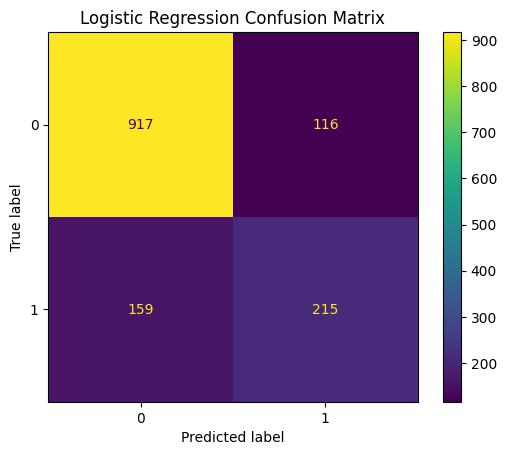

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    baseline_model, 
    X_test, 
    y_test
)

plt.title("Logistic Regression Confusion Matrix")
plt.show()